# Extending an existing pipeline

One of the major strenghts of DataJoint is the ease at which you can take an existing data pipeline and extend it with your own tables, performing new analysis. In this session, you will continue to work in a group to:

1. explore and understand an existing data pipeline
2. extend the data pipeline with new analysis

Let's get started!

## Importing an existing pipeline

As always, let's go ahead and import packages. We are also importing packages to perform analysis with.

In [1]:
import datajoint as dj

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

We are provided access to an existing pipeline defined in `workshop.calcium`. Let's go ahead and import it!

In [2]:
import workshop.calcium as ca

Connecting eywalker@workshop-db.datajoint.io:3306


Let's take a look at the ERD of the pipeline to get an overview.

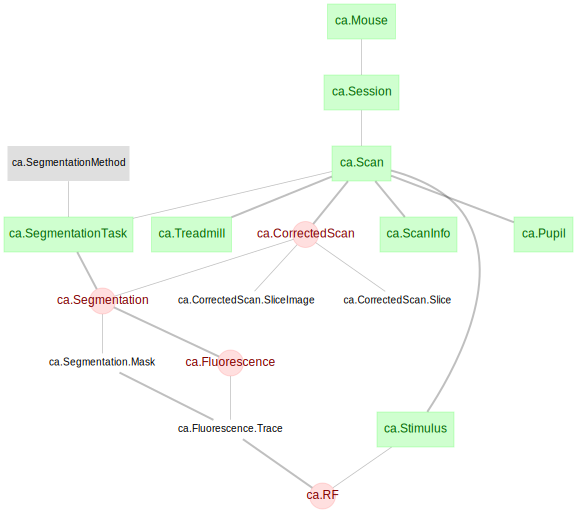

In [3]:
dj.ERD(ca)

As you may be able to guess, this pipeline defines workflow for a multi-photon fluorescent functional imaging (Ca2+ imaging) of mouse. During a scan, the mouse may be presented visual stimulus (`ca.Stimulus`), and we might record the mouse's pupil information (`ca.Pupil`) and it's running state (`ca.Treadmill`).

Go ahead and take some time to explore the pipeline. See if you can query the pipeline to gain better insights!

# Task Part 1 (25 min)

Carefully study the mouse's pupil information (`ca.Pupil`) and running state information (`ca.Treadmill`).

1. Pick a single scan for which both pupil and running state information is available.

2. For that scan, plot all pupil related information over time. What information is available?

3. For the same scan, plot running state traces over time

4. Do you see any relationship between pupil and running state? How would you go about quantifying this?

1) Pick a single scan with both `Pupil` and `Treadmill`

In [86]:
keys = (ca.Scan & ca.Pupil & ca.Treadmill).fetch('KEY')
key = keys[1]

2) Plot pupil information.

In [88]:
ca.Pupil() & key

mouse_id Unique animal ID,session session number,scan_idx scan ID,pupil_r vector of pupil radii synchronized with slice 1 frame times (pixels),pupil_x vector of pupil x positions synchronized with slice 1 frame times (pixels),pupil_y vector of pupil y positions synchronized with slice 1 frame times (pixels)
8804,1,3,=BLOB=,=BLOB=,=BLOB=


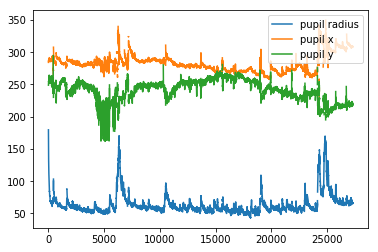

In [53]:
pupil_r, pupil_x, pupil_y = (ca.Pupil & key).fetch1('pupil_r', 'pupil_x', 'pupil_y')

plt.plot(pupil_r, label='pupil radius')
plt.plot(pupil_x, label='pupil x')
plt.plot(pupil_y, label='pupil y')
plt.legend(loc='upper right')

3) plot running state

In [89]:
ca.Treadmill & key

mouse_id Unique animal ID,session session number,scan_idx scan ID,treadmill_vel velocity of treadmill (may be positive or negative)
8804,1,3,=BLOB=


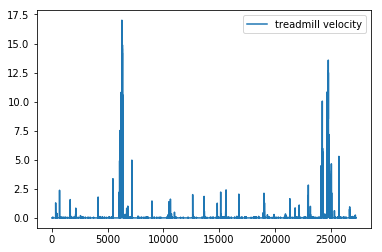

In [90]:
velocity = (ca.Treadmill & key).fetch1('treadmill_vel')

plt.plot(np.abs(velocity), label='treadmill velocity')
plt.legend()

Plot treadmill pupil size and treadmill velocity together

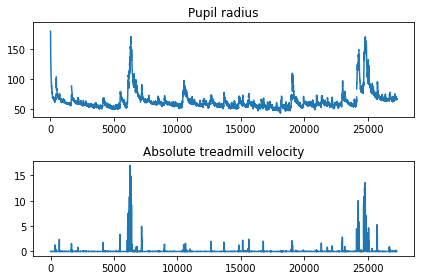

In [55]:
plt.subplot(2, 1, 1)
plt.plot(pupil_r, label='pupil radius')
plt.title('Pupil radius')
plt.subplot(2, 1, 2)
plt.plot(np.abs(velocity), label='treadmill velocity')
plt.title('Absolute treadmill velocity')
plt.tight_layout()

Let's compute Pearson correlation coefficient.

$$
r = E\left[\frac{(x - \mu_x)(y-\mu_y)}{\sigma_x \sigma_y}\right]
$$

In [91]:
r = pupil_r
v = np.absolute(velocity)

mu_r = np.nanmean(r)
mu_v = np.nanmean(v)

sigma_r = np.nanstd(r)
sigma_v = np.nanstd(v)

corr = np.nanmean((r - mu_r) * (v - mu_v) / sigma_r / sigma_v)

print('Correlation is {:.3f}'.format(corr))

Correlation is 0.495


# Task Part 2 (30 min)

Looks like we might be onto something quite interesting! Let's go ahead and implement a table that will compute and store the analysis results for all scans. When desigining the table, be sure to think about the following questions:

* What's the dependencies for the table?
* What does each row represent? (In other words, what's the entity that's getting computed?)
* What should be the tier for this table?

In [49]:
username = dj.config['database.user'] # using username information from database config
schema = dj.schema('{}_ca_extension'.format(username))

In [93]:
@schema
class PupilCorr(dj.Computed):
    definition = """
    -> ca.Pupil
    -> ca.Treadmill 
    ---
    pupil_corr :  float   # correlation between pupil radius and locomotion velccity
    """
    
    def make(self, key):
        print('Working on ', key)
        r = (ca.Pupil & key).fetch1('pupil_r')
        v = (ca.Treadmill & key).fetch1('treadmill_vel')
        v = np.abs(v)
        
        mu_r = np.nanmean(r)
        mu_v = np.nanmean(v)

        sigma_r = np.nanstd(r)
        sigma_v = np.nanstd(v)

        corr = np.nanmean((r - mu_r) * (v - mu_v) / sigma_r / sigma_v)
        
        key['pupil_corr'] = corr
        self.insert1(key)

In [94]:
PupilCorr()

mouse_id Unique animal ID,session session number,scan_idx scan ID,pupil_corr correlation between pupil radius and locomotion velccity


In [95]:
PupilCorr.populate()

Working on  {'mouse_id': 8623, 'session': 1, 'scan_idx': 5}
Working on  {'mouse_id': 8804, 'session': 1, 'scan_idx': 3}


In [96]:
PupilCorr()

mouse_id Unique animal ID,session session number,scan_idx scan ID,pupil_corr correlation between pupil radius and locomotion velccity
8623,1,5,0.438937
8804,1,3,0.495284


In [97]:
PupilCorr.populate()

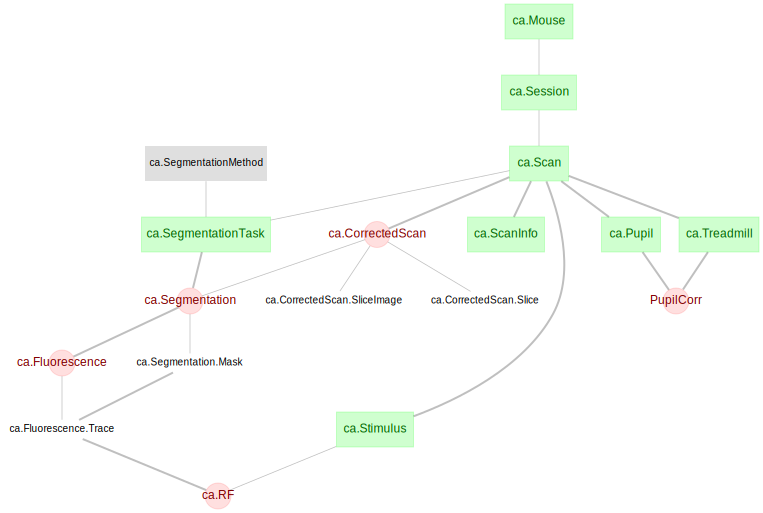

In [100]:
dj.ERD(ca) + dj.ERD(schema)